--- INICIANDO EJECUCIÓN DEL PROYECTO ---
>> Datos cargados correctamente.

--- MUESTRA DE DATOS ORIGINALES (RAW) ---
Así se ven los datos recién salidos del archivo (nota las columnas de texto):


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0



--- AUDITORÍA DE CALIDAD DE DATOS ---


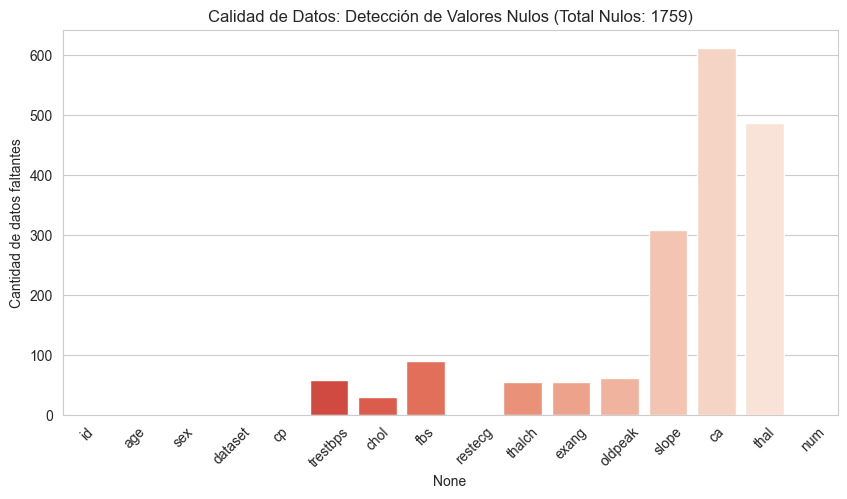

 -> Filas duplicadas detectadas para eliminar: 0
 -> Limpieza completada. Se mantuvieron 299 de 920 filas.

--- TRANSFORMACIÓN Y CODIFICACIÓN (ETL) ---
Generando diccionario de codificación (Crucial para interpretar el modelo):

[DICCIONARIO DE CODIFICACIÓN] ¿Cómo lee el modelo los textos?


,Columna,Valor Original,Código Numérico
0,sex,Female,0
1,sex,Male,1
2,dataset,Cleveland,0
3,dataset,Hungary,1
4,dataset,VA Long Beach,2
5,cp,asymptomatic,0
6,cp,atypical angina,1
7,cp,non-anginal,2
8,cp,typical angina,3
9,fbs,False,0



--- COMPARATIVA VISUAL: TEXTO ORIGINAL VS NÚMEROS ---


,sex,dataset,cp,fbs,restecg,exang,slope,thal,sex_codificado,dataset_codificado,cp_codificado,fbs_codificado,restecg_codificado,exang_codificado,slope_codificado,thal_codificado
0,Male,Cleveland,typical angina,True,lv hypertrophy,False,downsloping,fixed defect,1,0,3,1,0,0,0,0
1,Male,Cleveland,asymptomatic,False,lv hypertrophy,True,flat,normal,1,0,0,0,0,1,1,1
2,Male,Cleveland,asymptomatic,False,lv hypertrophy,True,flat,reversable defect,1,0,0,0,0,1,1,2
3,Male,Cleveland,non-anginal,False,normal,False,downsloping,normal,1,0,2,0,1,0,0,1
4,Female,Cleveland,atypical angina,False,lv hypertrophy,False,upsloping,normal,0,0,1,0,0,0,2,1


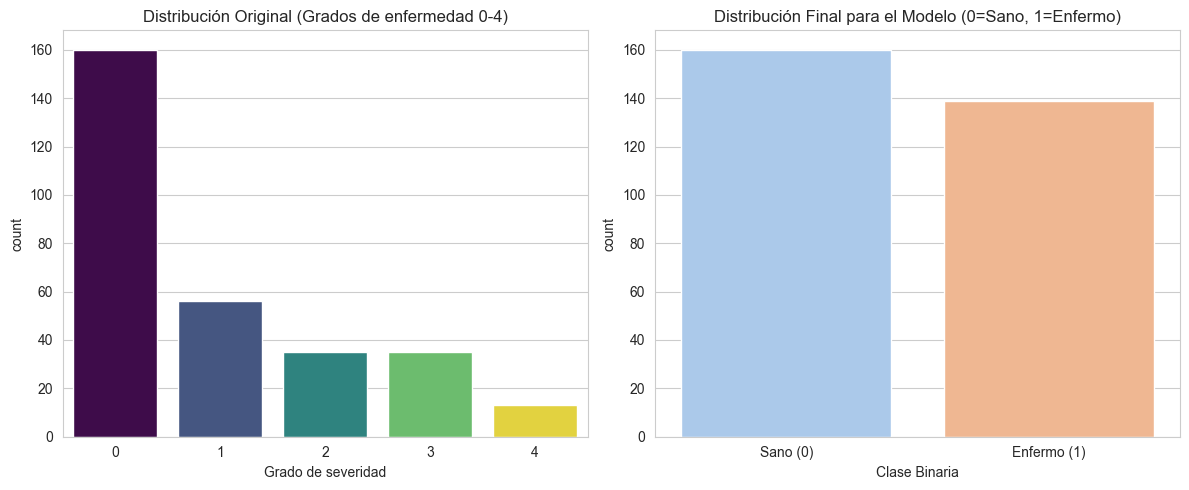

 -> Variable objetivo 'num' binarizada exitosamente.

[MODELO] Precisión (Accuracy) en Test Set: 0.85

[XAI - TÉCNICA 1] Calculando Permutation Importance...


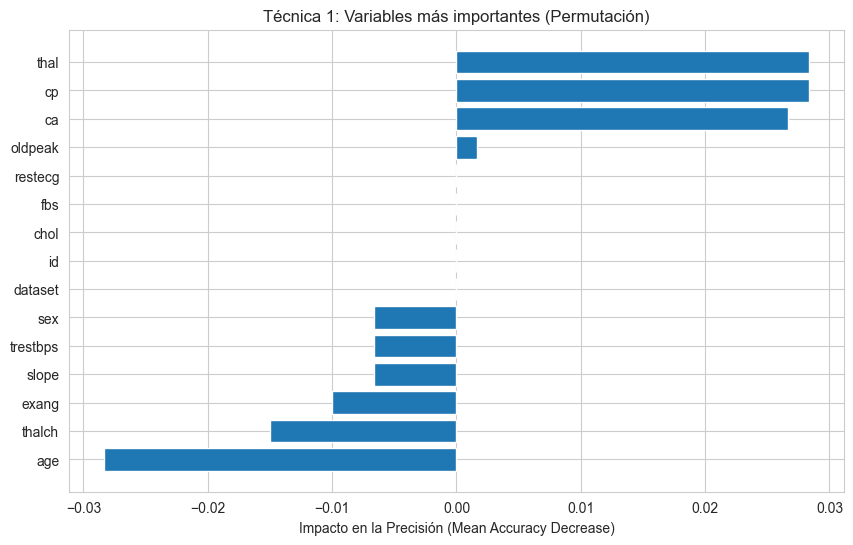


[XAI - TÉCNICA 2] Calculando valores SHAP...


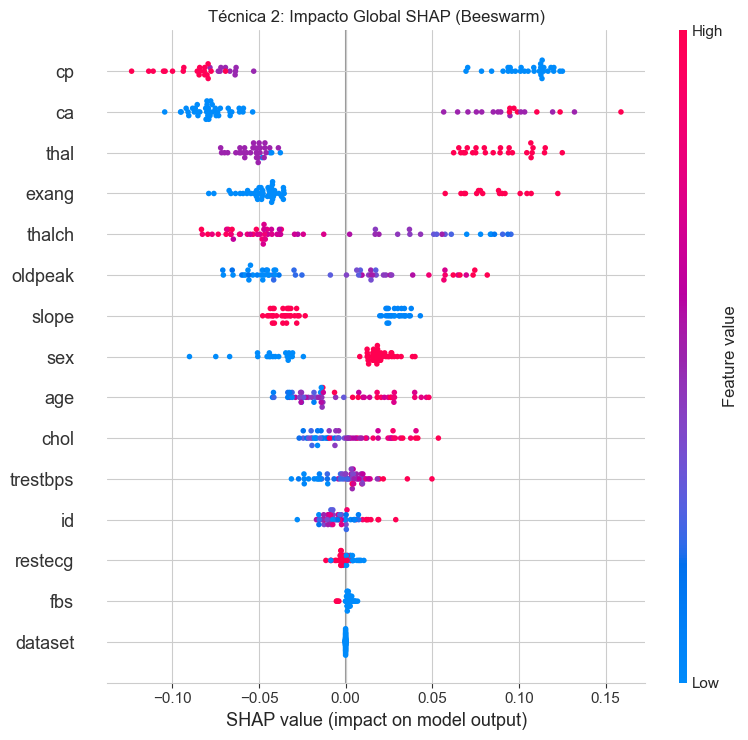


[XAI - CASO INDIVIDUAL] Analizando al Paciente #0 del Test Set...
 -> El modelo predice: ENFERMEDAD


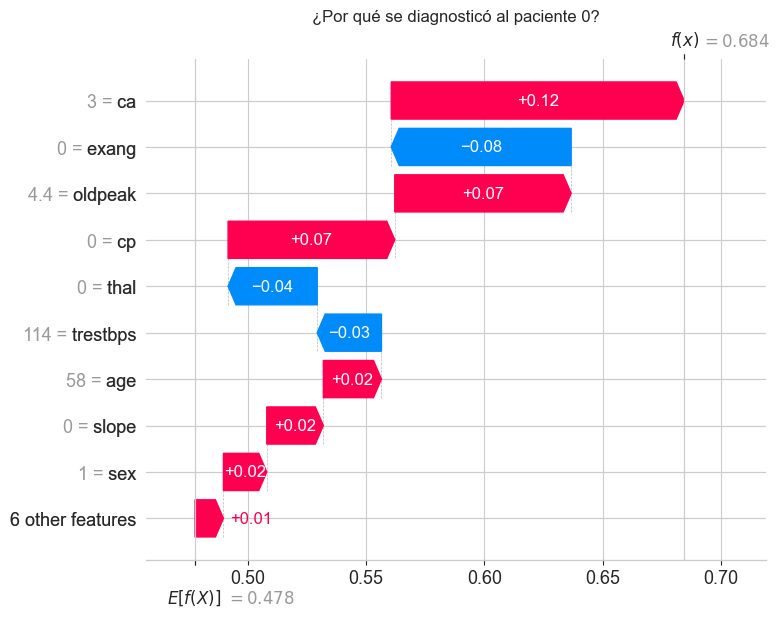


[ÉTICA] Auditoría de Sesgo Algorítmico (Hombres vs Mujeres)...


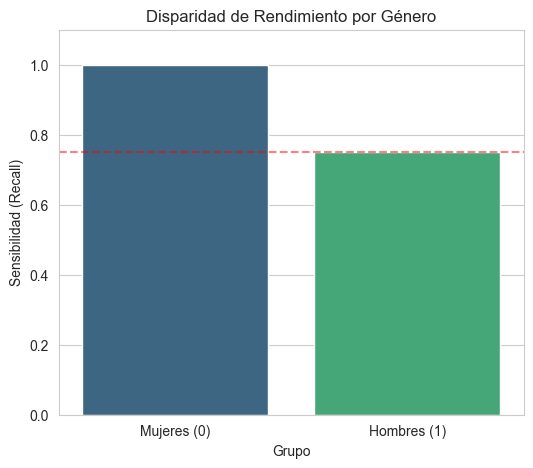

 -> Sensibilidad en Mujeres: 1.00
 -> Sensibilidad en Hombres: 0.75

[CONCLUSIÓN ÉTICA] Diferencia de rendimiento: 0.25
ALERTA: Existe un sesgo significativo. El modelo no es justo.
Esto representa un riesgo ético grave si se implementa en hospitales.

--- FIN DEL PROCESO ---


In [7]:
# =============================================================================
# PROYECTO FINAL: XAI, ÉTICA Y CALIDAD EN ML
# Dataset: Heart Disease UCI
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Configuración visual para gráficos profesionales
sns.set_style("whitegrid")
plt.rcParams.update({'figure.max_open_warning': 0})

print("--- INICIANDO EJECUCIÓN DEL PROYECTO ---")

# =============================================================================
# 1. CARGA DE DATOS Y ANÁLISIS DE CALIDAD VISUAL (Rúbrica: Calidad de Datos)
# =============================================================================
# URL del dataset.
url = "heart_disease_uci.csv" 
# url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/heart.csv"

try:
    df = pd.read_csv(url)
    print(">> Datos cargados correctamente.")
except:
    print(">> Error cargando archivo. Asegúrate de que el .csv esté correcto.")
    raise SystemExit("Deteniendo ejecución.")

# --- A. INSPECCIÓN VISUAL INICIAL ---
print("\n--- MUESTRA DE DATOS ORIGINALES (RAW) ---")
print("Así se ven los datos recién salidos del archivo (nota las columnas de texto):")
display(df.head())

# --- B. AUDITORÍA DE CALIDAD (VISUALIZACIÓN) ---
print("\n--- AUDITORÍA DE CALIDAD DE DATOS ---")
nulos = df.isnull().sum()
duplicados = df.duplicated().sum()

# Visualización 1: Mapa de Nulos por Columna
plt.figure(figsize=(10, 5))
sns.barplot(x=nulos.index, y=nulos.values, palette='Reds_r', hue=nulos.index, legend=False)
plt.xticks(rotation=45)
plt.title(f"Calidad de Datos: Detección de Valores Nulos (Total Nulos: {nulos.sum()})")
plt.ylabel("Cantidad de datos faltantes")
plt.show()

print(f" -> Filas duplicadas detectadas para eliminar: {duplicados}")

# Limpieza
initial_shape = df.shape
df_clean = df.dropna().drop_duplicates()
final_shape = df_clean.shape
print(f" -> Limpieza completada. Se mantuvieron {final_shape[0]} de {initial_shape[0]} filas.")

# =============================================================================
# 2. PRE-PROCESAMIENTO TRANSPARENTE Y CODIFICACIÓN
# =============================================================================
print("\n--- TRANSFORMACIÓN Y CODIFICACIÓN (ETL) ---")

# Guardamos una copia de las columnas de texto originales para comparar después
cat_columns = df_clean.select_dtypes(include=['object']).columns
df_text_backup = df_clean[cat_columns].copy()

# --- A. CODIFICACIÓN (Label Encoding) ---
label_encoders = {}
df_encoded = df_clean.copy()

print("Generando diccionario de codificación (Crucial para interpretar el modelo):")
# Creamos una lista para mostrar la tabla de equivalencias
encoding_map = []

for col in cat_columns:
    le = LabelEncoder()
    # Convertimos a string por seguridad y transformamos
    df_encoded[col] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le
    
    # Guardamos qué significa cada número
    classes = le.classes_
    for i, cls in enumerate(classes):
        encoding_map.append({'Columna': col, 'Valor Original': cls, 'Código Numérico': i})

# Visualización 2: Tabla de Mapeos (Diccionario de Datos)
df_mapping = pd.DataFrame(encoding_map)
print("\n[DICCIONARIO DE CODIFICACIÓN] ¿Cómo lee el modelo los textos?")
display(df_mapping)

# Normalización de nombres
df_encoded.columns = [c.lower() for c in df_encoded.columns]

# --- B. COMPARATIVA: ANTES VS DESPUÉS ---
print("\n--- COMPARATIVA VISUAL: TEXTO ORIGINAL VS NÚMEROS ---")
comparison_df = pd.concat([df_text_backup.reset_index(drop=True), df_encoded[cat_columns].reset_index(drop=True)], axis=1)
# Renombramos para distinguir (sufijo _num para los numéricos)
new_cols = list(cat_columns) + [c + "_codificado" for c in cat_columns]
comparison_df.columns = new_cols
display(comparison_df.head())

# --- C. TRANSFORMACIÓN DEL TARGET (Binarización) ---
target_col = 'num' if 'num' in df_encoded.columns else 'target'
if target_col not in df_encoded.columns: target_col = df_encoded.columns[-1]

# Visualización 3: Transformación de la variable objetivo
plt.figure(figsize=(12, 5))

# Gráfico Izquierda: Distribución Original (0, 1, 2, 3, 4)
plt.subplot(1, 2, 1)
sns.countplot(x=target_col, data=df_encoded, palette='viridis', hue=target_col, legend=False)
plt.title("Distribución Original (Grados de enfermedad 0-4)")
plt.xlabel("Grado de severidad")

# Transformación
df_encoded[target_col] = df_encoded[target_col].apply(lambda x: 1 if x > 0 else 0)

# Gráfico Derecha: Distribución Final (Binaria)
plt.subplot(1, 2, 2)
sns.countplot(x=target_col, data=df_encoded, palette='pastel', hue=target_col, legend=False)
plt.title("Distribución Final para el Modelo (0=Sano, 1=Enfermo)")
plt.xlabel("Clase Binaria")
plt.xticks([0, 1], ['Sano (0)', 'Enfermo (1)'])

plt.tight_layout()
plt.show()

print(f" -> Variable objetivo '{target_col}' binarizada exitosamente.")

# Asignamos al dataframe final para que el resto del script funcione
df_clean = df_encoded

# =============================================================================
# 3. ENTRENAMIENTO DEL MODELO (Rúbrica: Modelo Supervisado)
# =============================================================================
X = df_clean.drop(target_col, axis=1)
y = df_clean[target_col]

# División 80% Entrenamiento / 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo: Random Forest Classifier
# Justificación: Maneja bien relaciones no lineales y es ideal para XAI con SHAP.
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

acc = accuracy_score(y_test, model.predict(X_test))
print(f"\n[MODELO] Precisión (Accuracy) en Test Set: {acc:.2f}")

# =============================================================================
# 4. TÉCNICA XAI 1: PERMUTATION IMPORTANCE (Rúbrica: Técnica A)
# =============================================================================
# Esta técnica responde: "¿Qué tanto cae la precisión si desordeno una variable?"
# Es excelente para comparar con SHAP.
print("\n[XAI - TÉCNICA 1] Calculando Permutation Importance...")

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Impacto en la Precisión (Mean Accuracy Decrease)")
plt.title("Técnica 1: Variables más importantes (Permutación)")
plt.show()

# =============================================================================
# 5. TÉCNICA XAI 2: SHAP (Rúbrica: Técnica B + Explicación Individual)
# =============================================================================
print("\n[XAI - TÉCNICA 2] Calculando valores SHAP...")

explainer = shap.TreeExplainer(model)
# Obtención robusta de valores (corrige el error de dimensiones listas vs arrays)
shap_values_raw = explainer.shap_values(X_test)

if isinstance(shap_values_raw, list):
    shap_values = shap_values_raw[1] # Formato lista (antiguo)
elif len(np.array(shap_values_raw).shape) == 3:
    shap_values = shap_values_raw[:, :, 1] # Formato array 3D (nuevo)
else:
    shap_values = shap_values_raw # Formato binario

# --- VISUALIZACIÓN GLOBAL (Summary Plot) ---
# Muestra impacto positivo/negativo de cada variable
plt.figure()
plt.title("Técnica 2: Impacto Global SHAP (Beeswarm)")
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.show()

# --- VISUALIZACIÓN LOCAL (Caso Individual) ---
# Rúbrica: "Explicaciones individuales de predicciones concretas"
print("\n[XAI - CASO INDIVIDUAL] Analizando al Paciente #0 del Test Set...")

# Usamos la API de explicación completa para waterfall plot
explanation = explainer(X_test)
# Ajuste de dimensión para waterfall
if len(explanation.shape) == 3:
    explanation_patient = explanation[0, :, 1] # Paciente 0, Clase 1
else:
    explanation_patient = explanation[0]

pred_val = model.predict(X_test.iloc[[0]])[0]
print(f" -> El modelo predice: {'ENFERMEDAD' if pred_val==1 else 'SANO'}")

plt.figure()
shap.plots.waterfall(explanation_patient, show=False)
plt.title(f"¿Por qué se diagnosticó al paciente 0?", fontsize=12)
plt.show()

# =============================================================================
# 6. ANÁLISIS ÉTICO Y DE SESGOS (Rúbrica: Reflexión Ética)
# =============================================================================
print("\n[ÉTICA] Auditoría de Sesgo Algorítmico (Hombres vs Mujeres)...")

# Identificar columna de sexo. Asumimos 'sex'. 
# Si usamos LabelEncoder: 0 suele ser Female, 1 suele ser Male (orden alfabético).
if 'sex' in X_test.columns:
    # Separamos los grupos
    mask_female = X_test['sex'] == 0
    mask_male = X_test['sex'] == 1
    
    # Calculamos Sensibilidad (Recall): Capacidad de detectar la enfermedad cuando existe.
    # Es la métrica más importante en medicina (evitar falsos negativos).
    rec_female = recall_score(y_test[mask_female], model.predict(X_test[mask_female]))
    rec_male = recall_score(y_test[mask_male], model.predict(X_test[mask_male]))
    
    # DataFrame para el gráfico
    bias_data = pd.DataFrame({
        'Grupo': ['Mujeres (0)', 'Hombres (1)'],
        'Sensibilidad (Recall)': [rec_female, rec_male]
    })
    
    # Visualización de la disparidad
    plt.figure(figsize=(6, 5))
    sns.barplot(x='Grupo', y='Sensibilidad (Recall)', data=bias_data, palette='viridis', hue="Grupo", legend=False)
    plt.title("Disparidad de Rendimiento por Género")
    plt.ylim(0, 1.1)
    plt.axhline(y=rec_male, color='r', linestyle='--', alpha=0.5)
    plt.show()
    
    print(f" -> Sensibilidad en Mujeres: {rec_female:.2f}")
    print(f" -> Sensibilidad en Hombres: {rec_male:.2f}")
    
    diff = abs(rec_female - rec_male)
    print(f"\n[CONCLUSIÓN ÉTICA] Diferencia de rendimiento: {diff:.2f}")
    if diff > 0.1:
        print("ALERTA: Existe un sesgo significativo. El modelo no es justo.")
        print("Esto representa un riesgo ético grave si se implementa en hospitales.")
    else:
        print("El modelo parece equilibrado, aunque se requiere validación externa.")
else:
    print("No se encontró la columna 'sex' para realizar el análisis ético.")

print("\n--- FIN DEL PROCESO ---")